In [1]:
import numpy as np
from math import pi, floor, ceil
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import pandas as pd

In [2]:
X_MIN = 0
X_MAX = pi
K = 100
grid = np.arange(X_MIN, X_MAX + (X_MAX - X_MIN) / K, (X_MAX - X_MIN) / K)
f = lambda x: np.sin(x) + 0.5
a = 0.25
r = 3
sigma = np.random.uniform(-a, a, K + 1)
L = 10
lambda_ = np.arange(0, 1 + 1.0 / L, 1.0 / L)
P = 0.95
epsilon = 0.01

In [3]:
def smoothing(x, alpha, r):
    nbrs = int(floor(r / 2))
    smoothed = np.zeros(x.shape[0] - nbrs - 1)
    for i in range(nbrs, x.shape[0] - nbrs):
        window = x[i - nbrs: i + nbrs + 1]
        smoothed[i - 1] = np.exp(1 / np.sum(alpha) * np.sum(alpha * np.log(window)))        
    return smoothed

In [4]:
def noise_criteria(x):
    return np.max(np.abs(np.diff(x)))

def metric_criteria(x, y):
    return np.max(np.abs(x - y))

def distance_to_ideal(cr1, cr2):
    return np.max(np.array([cr1, cr2]))

In [5]:
def generate_alpha(r, N):
    all_alpha = np.zeros((N, r))
    for i in range(N):
        alpha = np.zeros(r)
        alpha[floor(alpha.shape[0] / 2)] = np.random.uniform()
        total_sum = alpha[floor(alpha.shape[0] / 2)]
        for i in range(ceil(alpha.shape[0] / 2), r - 1):
            alpha[i] = np.random.uniform(0, 1 - total_sum) / 2
            total_sum += alpha[i] * 2
        alpha[-1] = (1 - total_sum) / 2
        alpha[:floor(alpha.shape[0] / 2)] = np.flip(alpha[ceil(alpha.shape[0] / 2):])
        all_alpha[i] = alpha
    return all_alpha

In [8]:
origin = f(grid)
noised = f(grid) + sigma
N = int(np.log(1 - P) / np.log(1 - epsilon / (X_MAX - X_MIN)))
alphas = generate_alpha(r, N)

report = pd.DataFrame(columns=['lambda', 'alpha', 'J*', 'noise_criteria', 'metric_criteria', 'ideal_distance'])
for LAMBDA in tqdm_notebook(lambda_):
    best_alpha = np.zeros(r)
    J_star = np.inf
    best_noise = np.inf
    best_metric = np.inf
    for alpha in alphas: 
        smoothed = smoothing(noised, alpha, r)
        J = LAMBDA * noise_criteria(smoothed) + (1 - LAMBDA) * metric_criteria(smoothed, origin[floor(r / 2):-floor(r / 2)])
        if J < J_star:
            J_star = J
            best_alpha = alpha
            best_noise = noise_criteria(smoothed)
            best_metric = metric_criteria(smoothed, origin[floor(r / 2):-floor(r / 2)])

    d = distance_to_ideal(best_metric, best_noise)
    to_insert = pd.Series(np.array([LAMBDA, best_alpha, J_star, best_noise, best_metric, d]), index=report.columns)
    report = report.append(to_insert, ignore_index=True)


In [22]:
np.round(report.loc[0]['alpha'], 2)

array([0.43, 0.15, 0.43])

In [29]:
for i, row in report.iterrows():
    report.set_value(i, 'alpha', np.round(row['alpha'], 2))
report = report.round(2)

C:\Users\Boris Feldman\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


In [13]:
best_smoothed = smoothing(f(grid) + sigma, report.loc[10].alpha, 3)

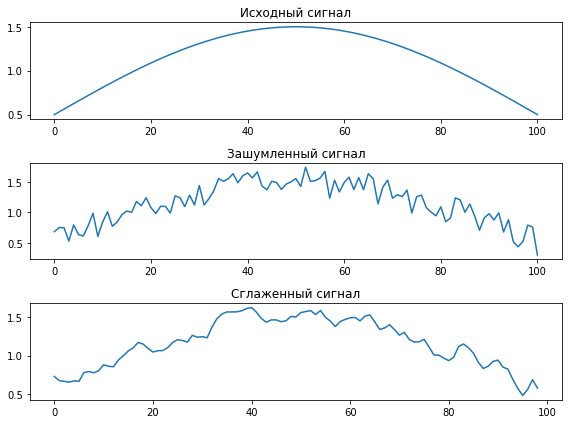

In [20]:
plt.figure(figsize=[8,6])
plt.subplot(3, 1, 1)
plt.title('Исходный сигнал')
plt.plot(f(grid))
plt.subplot(3, 1, 2)
plt.title('Зашумленный сигнал')
plt.plot(f(grid) + sigma)
plt.subplot(3, 1, 3)
plt.title('Сглаженный сигнал')
plt.plot(best_smoothed)
plt.tight_layout()
plt.savefig('pic.png')